### Importing Libraries

In [ ]:
# Standard libs
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import requests
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import scipy.stats as stats
import time

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import nltk
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Translation
from deep_translator import GoogleTranslator
from tenacity import retry, stop_after_attempt, wait_fixed, retry_if_result, RetryError

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

# Utilities
from SentAn_cleaning_and_preprocessing import *
from SentAn_visualisations import *
from SentAn_machine_learning import *

[nltk_data] Downloading package stopwords to /Users/ryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /Users/ryan/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Chapter 1. Exploratory Data Analysis of Customer Reviews 

### Part I: Loading and Initial Preparations & Observations of Data

First we seek to take a look and analyze initial general information of our main dataset "olist_order_reviews", which gives us the main data for analysis which is the `review_comment_message`

In [ ]:
brazil_database_path = "/app/data/brazil_dataset.db"

#Connecting to Main Database
conn = sqlite3.connect(brazil_database_path) 

#Importing the main reviews dataset
df = pd.read_sql_query("SELECT * FROM olist_order_reviews_dataset;", conn)
df = pd.DataFrame(df)

#Dropping index columns for now
df = df.drop('index', axis=1)

#Looking at general information of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [943]:
#Checking for null objects
null_counts = df.isnull().sum()
print(null_counts)

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


From our initial analysis, we see that the table consists of 6 columns, `review_id`, `order_id`, `review_score`, `review_comment_title`, `review_comment_message`, `review_creation_date`, `review_answer_timestamp`. Our main column of analsyis, is the `review_comment_message` which consists of order reviews that are written in Portuguese 

Since we are interested in applying sentiment analysis not only as a whole, but also by category, we import relevant tables (i.e. we want to extract `order_id`, `product_id`, `product_category_name` and `product_category_name_english` from all relevant tables to join into our reviews dataframe)

In [944]:
#1) Importing the order_items dataset
df_order = pd.read_sql_query("SELECT * FROM olist_order_items_dataset;", conn)
df_order = pd.DataFrame(df_order)

# Selecting the relevant columns, 'order_id' and 'product_id'
df_order = df_order[['order_id', 'product_id']]

#2) Importing the olist_products_datasets
df_products = pd.read_sql_query("SELECT * FROM olist_products_dataset;", conn)
df_products = pd.DataFrame(df_products)

# Selecting the relevant columns, 'product_id' and 'product_category_name'
df_products = df_products[['product_id','product_category_name']]

#3) Converting Portugese product_category_names into English
df_category_translation = pd.read_sql_query("SELECT * FROM product_category_name_translation;", conn)
df_category_translation  = pd.DataFrame(df_category_translation)

# Selecting the relevant columns, 'product_category_name' and 'product_category_name_english'
df_category_translation = df_category_translation[['product_category_name','product_category_name_english']]

#### Merging Tables

Once we have selected the relevant columns from the relevant tables, we will now merge all of them by common keys to further combinine into the main reviews dataframe.

In [945]:
# Step 1: Merge df and df_order on 'order_id'
df_1 = df.merge(df_order, on='order_id', how='inner')

# Step 2: Merge df_1 with df_products on 'product_id'
df_2 = df_1.merge(df_products, on='product_id', how='inner', suffixes=('', '_product'))

# Step 3: Merge df_2 with df_category_translation on 'product_category_name'
df_comments = df_2.merge(df_category_translation, on='product_category_name', how='inner')

Once we have obtained our main table for future analysis, 'df_comemnts', we will futher clean the data by combining values from `review_comment_title` into `review_comment_message`. We do this as we anticipate dropping the `review_comment_title` column as a whole but we do not want to lose valuable insights in the title.

In [946]:
# Combining 'review_comment_title' into 'review_comment_message' only if 'review_comment_title' is not null, doing this because, there is value in doing sentiment analysis on the words in the titles as well
df_comments['review_comment_message'] = np.where(
    df_comments['review_comment_title'].notna(),
    df_comments['review_comment_title'] + " " + df_comments['review_comment_message'] ,
    df_comments['review_comment_message']
)

#Example of Merging
print(df_comments.loc[24,['review_comment_title', 'review_comment_message']])

review_comment_title                                        Super recomendo
review_comment_message    Super recomendo Vendedor confiável, produto ok...
Name: 24, dtype: object


After the merge, we see that the modified table has 110,750 rows, far more than the original dataframe of only reviews. This means that there are duplicates within the table and so we choose to drop duplicates of `order_id` since we are looking to analyse only exclusive review comments for each order, and keeping duplicates would result in inaccurate analysis and skewed results.

In [947]:
#Since we have merged multiple tables, duplicates might have arisen, therefore, we can remove duplicates on `order_id` as such
print("Number of rows before dropping duplicates:", len(df_comments))
df_comments = df_comments.drop_duplicates(subset=['order_id'])
print("Number of rows after dropping duplicates:", len(df_comments))

#Selecting the relevant columns for analysis
df_comments = df_comments[['product_id','product_category_name','product_category_name_english','review_score','review_comment_message','review_creation_date', 'review_answer_timestamp']]

# Since we are looking to do Sentiment Analysis - as a whole and by categories, let us view the difference between non-null values of `review_comment_message` on df and df_comments to determine if there is significant loss of review_comment_message when tables are merged.
df_comments_merged = df_comments.dropna(subset=['review_comment_message'])

df_comments_merged.info()

Number of rows before dropping duplicates: 110750
Number of rows after dropping duplicates: 96517
<class 'pandas.core.frame.DataFrame'>
Index: 39666 entries, 4 to 110749
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_id                     39666 non-null  object
 1   product_category_name          39666 non-null  object
 2   product_category_name_english  39666 non-null  object
 3   review_score                   39666 non-null  int64 
 4   review_comment_message         39666 non-null  object
 5   review_creation_date           39666 non-null  object
 6   review_answer_timestamp        39666 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [948]:
df_nonmerged = df.dropna(subset=['review_comment_message'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


From the observation above, we can see that the original dataframe, *df* (with 40,977 non-null 'review_comment_messages') when compared to the *df_comments_merged* dataframe (with 39,666 non-null 'review_comment_messages') we will lose roughly `1,311` worth of rows of 'review_comment_messages' for analysis (i.e. 40,977 - 39,666 = 1,311). Since the information loss for these non-null values make up about only $$\frac{1,311}{40,977}\times 100\% = 3.20\%  $$ of the total non-null review_comment_messages, we consider the information loss to be insignificant and will proceed to just use the `df_comnments_merged` dataframe to improve efficiency.

#### Adding Indices to the Comments

We choose to add indices to the comments as it helps us with easier analysis and grouping of results

In [949]:
#Adding corresponding Index to each review score and their respective comment, and changing variable name to df_comments for efficient analysis.
df_comments = df_comments_merged.reset_index(drop=True)

df_comments.head()

,product_id,product_category_name,product_category_name_english,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,52c80cedd4e90108bf4fa6a206ef6b03,ferramentas_jardim,garden_tools,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
1,3880d25d502b15b1de6fddc42ad1d67a,esporte_lazer,sports_leisure,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
2,61a4100ccd6d9c4c808a1fd954ddb8ad,eletroportateis,small_appliances,4,recomendo aparelho eficiente. no site a marca ...,2018-05-22 00:00:00,2018-05-23 16:45:47
3,acffe5d7cd56e6b564cf6841486644ff,beleza_saude,health_beauty,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
4,6871a3c157d6f51697e887f3c3598479,informatica_acessorios,computers_accessories,5,"Super recomendo Vendedor confiável, produto ok...",2018-05-23 00:00:00,2018-05-24 03:00:01


### Part II: Cleaning and Pre-Processing the Dataset

Since we are only interested in words for sentiment analysis, from the review comments, we can remove/alter **Regular Expressions (RegEx)** within each review comment such as:

    i. Removing Line Breaks

    ii. Removing Sites and Hyperlinks

    iii. Removing Numbers (e.g. Dates, Money, etc.)

    iv. Replacing Negations

    v. Removing Special Characters (e.g. emojis, punctuations)

    vi. Removing Remaining Whitespaces

Additonal Pre-Processing:

    vii. Remove Stopwords

    viii. Stemming and Lemmatization

    ix. Parsing Date columns as Dates 

Source: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

#### 1) Removing Linebreaks

Line breaks occur when text is divided into separate lines, often to improve readability or to separate different sections of text. In sentiment analysis, line breaks can interfere with text processing because they may be interpreted as additional, unnecessary features or as separators, making it harder for machine learning models to accurately understand the context and sentiment of the text. Thus removing linebreaks are essential to ensure - normalization, consistency and improving model accuracy

In [950]:
# Creating a list of comment reviews
reviews= list(df_comments['review_comment_message'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline,idx_list=[48])


--- Text 1 ---

Before:
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

After:
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



#### 2) Removing Hyperlinks

Hyperlinks are references (often starting with "http://", "https://", or "www") that direct users to external websites. They are commonly used in text to link to additional resources, articles, or related content. In the context of sentiment analysis, hyperlinks do not contribute to understanding the sentiment of the text and may instead introduce noise or irrelevant information. Thus, we remove hyperlinks as they are - irrelevant to sentiment, help to reduce noise, and improve model focus

In [951]:
# Applying RegEx
reviews_hyperlinks = re_hyperlinks(reviews_breakline)
df_comments['re_hyperlinks'] = reviews_hyperlinks

# Find the index of rows where 'review_comment_message' has the value with a hyperlink
index_list = df_comments.index[df_comments['review_comment_message'] == 'comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/'].tolist()
print("Indexes:", index_list)

# Verifying results
print_step_result(reviews_breakline, reviews_hyperlinks, idx_list=[10304])

Indexes: []
--- Text 1 ---

Before:
as cores não corresponde comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/

After:
as cores não corresponde comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 



#### 3) Removing Numbers

Numbers are any numerical values (e.g., integers, decimals, percentages) present in the text. These can represent quantities, dates, prices, or other data points. In sentiment analysis, numbers often don’t carry direct meaning when determining the sentiment of a message. Thus, we remove them to improve consistency in preprocesing.

We do so by removing 3 Types
1. Dates (Replacing with the word `data` which means 'date' in Portuguese)
2. Money (Replacing with the word `dinheiro` which means 'money' in Portuguese)
3. Remaining Numbers ((Replacing with the word `numero` which means 'number' in Portuguese))

In [952]:
## 1. Removing Dates

# Applying RegEx
reviews_dates = re_dates(reviews_hyperlinks)
df_comments['re_dates'] = reviews_dates

# Find the index of rows where 'review_comment_message' has the value with a date
index_list = df_comments.index[df_comments['review_comment_message'] == 'Realizei a compra do produto no dia 10/10/2017, e o pagamento foi confirmado no dia 12!! O prazo para entrega foi até o dia 01/10, porem, até agora não recebi nada!!'].tolist()
print("Indexes:", index_list)

# Verifying results
print_step_result(reviews_hyperlinks, reviews_dates, idx_list=[10946]) 

Indexes: [10946]
--- Text 1 ---

Before:
Realizei a compra do produto no dia 10/10/2017, e o pagamento foi confirmado no dia 12!! O prazo para entrega foi até o dia 01/10, porem, até agora não recebi nada!!

After:
Realizei a compra do produto no dia  data , e o pagamento foi confirmado no dia 12!! O prazo para entrega foi até o dia 01/10, porem, até agora não recebi nada!!



In [953]:
## 2. Removing Money Values

# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Find the index of rows where 'review_comment_message' has the value with a dollar sign
index_list = df_comments.index[df_comments['review_comment_message'] == 'A maioridade das cameras de espiã em baixo de R$100 são lixo. Raramente funcionam, e com qualidade péssima de video e som. Investi um pouco mais aqui e fiquei impressionado com imagem e som. Recomendo'].tolist()
print("Index:", index_list)

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[14952])

Index: []
--- Text 1 ---

Before:
Boa qualidade, vale preço A maioridade das cameras de espiã em baixo de R$100 são lixo. Raramente funcionam, e com qualidade péssima de video e som. Investi um pouco mais aqui e fiquei impressionado com imagem e som. Recomendo

After:
Boa qualidade, vale preço A maioridade das cameras de espiã em baixo de  dinheiro  são lixo. Raramente funcionam, e com qualidade péssima de video e som. Investi um pouco mais aqui e fiquei impressionado com imagem e som. Recomendo



In [954]:
## 3. Removing Remainding Numbers

# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Find the index of rows where 'review_comment_message' has the value with a number
index_list = df_comments.index[df_comments['review_comment_message'] == 'Mochila de otimo tamanho para o meu filho de 3 anos... boa qualidade.. tamanho Ideal'].tolist()
print("Index:", index_list)

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[14936])

Index: [14936]
--- Text 1 ---

Before:
Mochila de otimo tamanho para o meu filho de 3 anos... boa qualidade.. tamanho Ideal

After:
Mochila de otimo tamanho para o meu filho de  numero  anos... boa qualidade.. tamanho Ideal



#### 4) Replacing Negations

Since we are planning to remove characters and stopwords, we might lose the meaning of some phrases and important negative words (negations) such as **não** (which means 'not'). So, to not lose important information, we replace negation words with some common words (i.e. **negacao**) which also allude to a negative meaning.

In [955]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Find the index of rows where 'review_comment_message' has the value with a não (or related words)
index_list = df_comments.index[df_comments['review_comment_message'] == 'ATE AGORA O PRODUTO NÃO FOI ENTREGUE'].tolist()
print("Index:", index_list)

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[14939])

Index: []
--- Text 1 ---

Before:
ENTREGA ATE AGORA O PRODUTO NÃO FOI ENTREGUE

After:
ENTREGA ATE AGORA O PRODUTO  negação  FOI ENTREGUE



#### 5) Removing Special Characters

Special characters refer to any non-alphanumeric symbols or punctuation marks that are not part of standard letters or numbers. 
Examples include: `Punctuations`, `Emojis` and `Mathematical Symbols`. 
These characters can appear in the text for various reasons, such as emphasis, emojis, or separating different parts of a sentence. However, in sentiment analysis, many special characters do not contribute directly to the understanding of the sentiment expressed in the text. Thus, we remove them to - reduce noise and improve text representation

In [956]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Find the index of rows where 'review_comment_message' has the value with a special character
index_list = df_comments.index[df_comments['review_comment_message'] == 'Esse produto é maravilhoso 😱'].tolist()
print("Index:", index_list)

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[15031])

Index: [15031]
--- Text 1 ---

Before:
Esse produto é maravilhoso 😱

After:
Esse produto é maravilhoso  



#### 6) Removing Remaining Whitespaces

Whitespace refers to any empty space in a text document. From the previous textpreprocessing procedures, white spaces have emerged or taken the place of certain exporessions. We choose to remove whitespaces as this ensures consistency, prevents processing errors, and improves word tokenization.

In [957]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Find the index of rows where 'review_comment_message' has the value with a whitespace
print("Index", [9])

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[9])

Index [9]
--- Text 1 ---

Before:
A compra foi realizada facilmente   A entrega foi efetuada muito antes do prazo dado   O produto já começou a ser usado e até o presente   sem problemas 

After:
A compra foi realizada facilmente A entrega foi efetuada muito antes do prazo dado O produto já começou a ser usado e até o presente sem problemas



#### Removing Stopwords

Stopwords are common words such as "the," "is," "in," "and," which appear frequently in text but carry little meaningful information in analysis.
We Remove Stopwords to -- "Reduce Noise" because Stopwords do not contribute significantly to the meaning of the text, and keeping them can clutter the data, making it harder for models to focus on important words. and "Improve Performance" because removing stopwords reduces the size of the text, allowing algorithms to process data faster and more efficiently without losing critical insights. By eliminating stopwords, we enhance the focus of the analysis on the words that matter most for tasks like sentiment analysis.

In [958]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total number of portuguese stopwords in the module: {len(pt_stopwords)}')
print(pt_stopwords[:5])

Total number of portuguese stopwords in the module: 207
['a', 'à', 'ao', 'aos', 'aquela']


In [959]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

# Find the index of rows where 'review_comment_message' has the value with a stopword
index_list = df_comments.index[df_comments['review_comment_message'] == 'As vezes acesso o site de uma determinada loja, seleciono o produto e vejo que não é vendido por aquela loja, desistindo da compra. Mas é por parceiros como este que não mais farei isso. Recomendo.'].tolist()
print("Index:", index_list)

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[15800])

Index: []
--- Text 1 ---

Before:
Satisfeita As vezes acesso o site de uma determinada loja seleciono o produto e vejo que negação é vendido por aquela loja desistindo da compra Mas é por parceiros como este que negação mais farei isso Recomendo

After:
satisfeita vezes acesso site determinada loja seleciono produto vejo negação vendido loja desistindo compra parceiros negação farei recomendo



#### Stemming

Stemming is the process of reducing words to their base or root form, such as changing "running" to "run" or "better" to "good."
We Use Stemming to - "Normalize Variations" Different word forms (e.g., "run," "running," "ran") carry the same meaning. Stemming reduces them to a single form, making the analysis more consistent and representative, also to "Improve Model Accuracy", by focusing on the root word, we reduce the complexity of the text, allowing the model to better identify patterns and relationships between words. Stemming helps to generalize the analysis and improve the efficiency of text processing in tasks like sentiment analysis.

In [960]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

# Find the index of rows where 'review_comment_message' has the value with an unstemmed word
print("Index", [0, 45, -1])

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

Index [0, 45, -1]
--- Text 1 ---

Before:
recebi bem antes prazo estipulado

After:
receb bem ant praz estipul

--- Text 2 ---

Before:
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After:
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before:
produto chegou ja devolver pois defeito negação segurar carga

After:
produt cheg ja devolv poi defeit neg segur carg



#### Parsing Date Columns as Dates

Furthermore, since we have date columns, to easily compute time difference and analysis which requires comparisons between dates, we decide to parse the relevant date columns as 'dates' using the `datetime` module

In [961]:
df_comments['review_creation_date'] = pd.to_datetime(df_comments['review_creation_date'])
df_comments['review_answer_timestamp'] = pd.to_datetime(df_comments['review_answer_timestamp'])

#Creating a column of difference between review creation and review response
df_comments['response_time'] = df_comments['review_answer_timestamp'] - df_comments['review_creation_date']
df_comments['response_time_hours'] = df_comments['response_time'].dt.days * 24 + df_comments['response_time'].dt.components['hours'] + df_comments['response_time'].dt.components['minutes'] / 60 + df_comments['response_time'].dt.components['seconds'] / 3600
df_comments['response_time_hours'] = df_comments['response_time_hours'].round(2)

#### Mapping English Category Names to Predefined Standardized Forms

In reviewing the english column names, `product_category_name_english`, we have observed that the categories are very specific and there are certain overlaps between each other. As such, we have decided to map these categories into broader less specific ones for efficient analysis 

In [962]:
#Mapping the dictionary of 'category_mapping' to 'product_category_name_english 
df_comments['broader_category_english'] = df_comments['product_category_name_english'].map(category_mapping)

#### Dataset Observation
As such, after the initial cleaning and preprocessing of the dataset, our dataset looks as such

In [963]:
df_comments.head()

,product_id,product_category_name,product_category_name_english,review_score,review_comment_message,review_creation_date,review_answer_timestamp,re_breakline,re_hyperlinks,re_dates,re_money,re_numbers,re_negation,re_special_chars,re_whitespaces,stopwords_removed,stemming,response_time,response_time_hours,broader_category_english
0,52c80cedd4e90108bf4fa6a206ef6b03,ferramentas_jardim,garden_tools,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado,Recebi bem antes do prazo estipulado,recebi bem antes prazo estipulado,receb bem ant praz estipul,0 days 22:02:06,22.04,Home & Living
1,3880d25d502b15b1de6fddc42ad1d67a,esporte_lazer,sports_leisure,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabém loj lannist ador compr internet segur ...,1 days 10:26:53,34.45,Sports & Leisure
2,61a4100ccd6d9c4c808a1fd954ddb8ad,eletroportateis,small_appliances,4,recomendo aparelho eficiente. no site a marca ...,2018-05-22,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente no site a marca ...,recomendo aparelho eficiente no site a marca d...,recomendo aparelho eficiente site marca aparel...,recom aparelh efici sit marc aparelh impress n...,1 days 16:45:47,40.76,Electronics & Appliances
3,acffe5d7cd56e6b564cf6841486644ff,beleza_saude,health_beauty,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.",Mas um pouco travando pelo valor ta Boa,Mas um pouco travando pelo valor ta Boa,pouco travando valor ta boa,pouc trav val ta boa,4 days 10:52:22,106.87,Health & Beauty
4,6871a3c157d6f51697e887f3c3598479,informatica_acessorios,computers_accessories,5,"Super recomendo Vendedor confiável, produto ok...",2018-05-23,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...",Super recomendo Vendedor confiável produto ok...,Super recomendo Vendedor confiável produto ok ...,super recomendo vendedor confiável produto ok ...,sup recom vend confi produt ok entreg ant praz,1 days 03:00:01,27.00,Electronics & Appliances


### Part III: Data Labelling and English Translation

#### Associating "positive-ness" and "negative-ness" to each word based on the review scores
For training a sentiment analysis model, we need the sentiment labels to apply a supervised Machine Learning approach. The dataset we have does not clearly define these sentiment label by saying wich comment is positive or negative. Thus, we decide that the best approach is to look at individual comments and label these comments using the `review_score` column to label our data into those two classes, `positive` and `negative`.

First we take a look at the distribution of review scores across all categories

In [964]:
# Calculate counts and percentages for each review score, sorted by score value
score_counts = df_comments['review_score'].value_counts().sort_index()
total_reviews = len(df_comments)
score_percentages = (score_counts / total_reviews * 100).round(1)

# Use score_counts and score_percentages in ascending order of scores
x_values = score_counts.index
y_values = score_counts.values
percentage_text = [f"{count}<br>{percentage}%" for count, percentage in zip(y_values, score_percentages)]

# Create bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=x_values,
    y=y_values,
    text=percentage_text,
    textposition="auto",
    marker=dict(
        color=y_values,
        colorscale='Viridis', 
        showscale=False 
    )
))

# Update layout for title and axes labels
fig.update_layout(
    title="Review Scores Distribution",
    xaxis_title="Review Score",
    yaxis_title="Count",
    xaxis=dict(type='category'),
)

fig.show()



The above shows a 'J-Shaped' Distribution, which, according to Hu et. al.(2009), is a common distribution for product reviews, potentially due to "Acquisition Bias" and  "Under-Reporting Bias"
Source: https://www.researchgate.net/publication/256294572_Overcoming_the_J-Shaped_Distribution_of_Product_Reviews

In this approach, let's consider that every comment with scores 1, 2 are negative comments. In the other hand, comments with score 3, 4 and 5 will be considered as positive.

In [965]:
# Labelling data with a sentiment label 
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['review_score'].map(score_map)

In [966]:
# Calculate the count and percentage of positive and negative reviews
sentiment_counts = df_comments['sentiment_label'].value_counts()
labels = sentiment_counts.index.tolist()
values = sentiment_counts.values.tolist()

# Calculate the percentages manually
total_reviews = sum(values)
percentages = [round((count / total_reviews) * 100, 1) for count in values]

# Format the values with commas and as strings
formatted_values = [f"{value:,.0f}" for value in values]

# Create custom text labels without "k" abbreviation
text_labels = [f"{label} <br> {formatted_value} <br> {percentage}%" for label, formatted_value, percentage in zip(labels, formatted_values, percentages)]

# Create funnel plot
fig = go.Figure(go.Funnel(
    y=labels,
    x=values,  
    text=text_labels,     
    texttemplate="%{text}",  
    hoverinfo="text",        
    marker=dict(
        color=['#0041C2', '#B80F0A'], 
    )
))

# Update layout
fig.update_layout(
    title="Funnel Plot of Positive and Negative Reviews",
    xaxis_title="Number of Reviews",
    yaxis=dict(showticklabels=False), 
)

fig.show()

#### Translating Portugese Reviews for Analsyis in English (part a and b, only run when uploading)

After performing our cleaning and pre-processing of Portuguese reviews, we decided that for visualisation, we would convert these reviews to English, in an attempt to allow ourselves and our audience to better understand the analysis and visualisations produced.

As such, we have decided to translate the `stopwords_removed` column. The reason why we decided to use the 'stopwords_removed' instead of 'stemming' is because the process of stemming might create phrases that do not exist or are incoherent, which makes translating harder and less efficient or accurate, thus we decide to use the `stopwords_removed` column to preserve as much information to be translated as possible.

##### a. Translating Reviews in 'stopwords_removed' into English [7 hour block]

In [463]:
#### THIS BLOCK RUNS FOR 7HRS, UHH TRY NOT TO RUN, I HAVE A FINALISED CSV VERSION OF IT 'reviews_table_for_sentiment_analysis' #######

# Apply the translation to each row in the dataframe
df_comments['review_en'] = df_comments['stopwords_removed'].apply(apply_translation_with_retry)

Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Translation failed: Request exception can happen due to an api connection error. Please check your connection and try again
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exceeded for text: 
Max retries exce

,product_id,product_category_name,product_category_name_english,review_score,review_comment_message,review_creation_date,review_answer_timestamp,re_breakline,re_hyperlinks,re_dates,re_money,re_numbers,re_negation,re_special_chars,re_whitespaces,stopwords_removed,stemming,response_time,response_time_hours,broader_category_english,sentiment_label,review_en
0,52c80cedd4e90108bf4fa6a206ef6b03,ferramentas_jardim,garden_tools,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado,Recebi bem antes do prazo estipulado,recebi bem antes prazo estipulado,receb bem ant praz estipul,0 days 22:02:06,22.04,Home & Living,positive,I received it well before the stipulated deadline
1,3880d25d502b15b1de6fddc42ad1d67a,esporte_lazer,sports_leisure,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabém loj lannist ador compr internet segur ...,1 days 10:26:53,34.45,Sports & Leisure,positive,"Congratulations Lannister Stores, I loved buyi..."
2,61a4100ccd6d9c4c808a1fd954ddb8ad,eletroportateis,small_appliances,4,recomendo aparelho eficiente. no site a marca ...,2018-05-22,2018-05-23 16:45:47,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente no site a marca ...,recomendo aparelho eficiente no site a marca d...,recomendo aparelho eficiente site marca aparel...,recom aparelh efici sit marc aparelh impress n...,1 days 16:45:47,40.76,Electronics & Appliances,positive,I recommend efficient device website brand dev...
3,acffe5d7cd56e6b564cf6841486644ff,beleza_saude,health_beauty,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,"Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.","Mas um pouco ,travando...pelo valor ta Boa.",Mas um pouco travando pelo valor ta Boa,Mas um pouco travando pelo valor ta Boa,pouco travando valor ta boa,pouc trav val ta boa,4 days 10:52:22,106.87,Health & Beauty,positive,little blocking value is good
4,6871a3c157d6f51697e887f3c3598479,informatica_acessorios,computers_accessories,5,"Super recomendo Vendedor confiável, produto ok...",2018-05-23,2018-05-24 03:00:01,"Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...","Super recomendo Vendedor confiável, produto ok...",Super recomendo Vendedor confiável produto ok...,Super recomendo Vendedor confiável produto ok ...,super recomendo vendedor confiável produto ok ...,sup recom vend confi produt ok entreg ant praz,1 days 03:00:01,27.00,Electronics & Appliances,positive,"I highly recommend the seller, reliable produc..."


From applying GoogleTranslate on the stopwords columns, we lose some translations (i.e. there are some reviews which cannot be translated). We presume that there are some reasons for this, primarily:
1. The use of Slang - which GoogleTranslate is unable to translate
2. Typo Mistakes which GoogleTranslate cannot recognize.

Furthermore, we have seen that there are about 39,666 - 39,542 = `124` values of reviews that are unable to be translated. Since this value makes up about only `0.3%` of the total reviews, we will choose to ignore these values in the English reviews and proceed to further analyse without them, and the information loss is not too significant

##### b. Selecting Relevant Columns for Analysis

Since the original df_comments still contains columns including the RegEx columns, we choose to remove them and rename certan columns for easier analysis

In [492]:
#Selecting Relevant Columns for Analysis
df_sentiment_analysis = df_comments.loc[:, ['product_id', 'product_category_name', 'product_category_name_english', 'broader_category_english', 'review_comment_message', 'stopwords_removed', 'stemming', 'review_en', 'review_score', 'sentiment_label','review_creation_date', 'review_answer_timestamp', 'response_time_hours']].rename(columns={
    'stopwords_removed': 'processed_review_comment_message', #Renaming 'stopwords_removed' to 'processed_review_comment_message'
    'stemming': 'stemmed_reviews'                            #Renaming 'stemming' to 'stemmed'
})

df_sentiment_analysis = df_sentiment_analysis.dropna(subset=['review_en'])

<class 'pandas.core.frame.DataFrame'>
Index: 39542 entries, 0 to 39665
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   product_id                        39542 non-null  object        
 1   product_category_name             39542 non-null  object        
 2   product_category_name_english     39542 non-null  object        
 3   broader_category_english          39542 non-null  object        
 4   review_comment_message            39542 non-null  object        
 5   processed_review_comment_message  39542 non-null  object        
 6   stemmed_reviews                   39542 non-null  object        
 7   review_en                         39542 non-null  object        
 8   review_score                      39542 non-null  int64         
 9   sentiment_label                   39542 non-null  object        
 10  review_creation_date              39542 non-null  d

,product_id,product_category_name,product_category_name_english,broader_category_english,review_comment_message,processed_review_comment_message,stemmed_reviews,review_en,review_score,sentiment_label,review_creation_date,review_answer_timestamp,response_time_hours
0,52c80cedd4e90108bf4fa6a206ef6b03,ferramentas_jardim,garden_tools,Home & Living,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipulado,receb bem ant praz estipul,I received it well before the stipulated deadline,5,positive,2017-04-21,2017-04-21 22:02:06,22.04
1,3880d25d502b15b1de6fddc42ad1d67a,esporte_lazer,sports_leisure,Sports & Leisure,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabém loj lannist ador compr internet segur ...,"Congratulations Lannister Stores, I loved buyi...",5,positive,2018-03-01,2018-03-02 10:26:53,34.45
2,61a4100ccd6d9c4c808a1fd954ddb8ad,eletroportateis,small_appliances,Electronics & Appliances,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente site marca aparel...,recom aparelh efici sit marc aparelh impress n...,I recommend efficient device website brand dev...,4,positive,2018-05-22,2018-05-23 16:45:47,40.76
3,acffe5d7cd56e6b564cf6841486644ff,beleza_saude,health_beauty,Health & Beauty,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travando valor ta boa,pouc trav val ta boa,little blocking value is good,4,positive,2018-02-16,2018-02-20 10:52:22,106.87
4,6871a3c157d6f51697e887f3c3598479,informatica_acessorios,computers_accessories,Electronics & Appliances,"Super recomendo Vendedor confiável, produto ok...",super recomendo vendedor confiável produto ok ...,sup recom vend confi produt ok entreg ant praz,"I highly recommend the seller, reliable produc...",5,positive,2018-05-23,2018-05-24 03:00:01,27.00


##### c. Removing Special Characters and English Stopwords

1. Removing Stopwords

From analysing the translated reviews, we see that there are subsequent stopwords that appear again, hence we need to remove and process these trnaslated English reviews.

In [568]:
# Examples of some portuguese stopwords
en_stopwords = stopwords.words('english')
print(f'Total number of portuguese stopwords in the module: {len(en_stopwords)}')
print(en_stopwords[:5])

Total number of portuguese stopwords in the module: 179
['i', 'me', 'my', 'myself', 'we']


In [569]:
#Defining English Review List for Transformation
review_en = df_sentiment_analysis['review_en'].tolist()

# Removing stopwords and looking at some examples
review_en_cleaned = [' '.join(stopwords_removal_en(review)) for review in review_en]
df_sentiment_analysis['review_en_cleaned'] = review_en_cleaned

# Find the index of rows where 'review_comment_message' has the value with a stopword
index_list = df_sentiment_analysis.index[df_sentiment_analysis['review_en'] == 'I received it well before the stipulated deadline'].tolist()
print("Index:", index_list)

print_step_result(review_en, review_en_cleaned, idx_list=[0])

Index: [0]
--- Text 1 ---

Before:
I received it well before the stipulated deadline

After:
received well stipulated deadline



2. Removing Special Characters for Cleaned English Reviews

Furthermore, the translation also filled in and added some punctuation for the English Reviews, so we will choose to remove them

In [570]:
#Defining Cleaned English Review List for Transformation
review_en_cleaned = df_sentiment_analysis['review_en_cleaned'].tolist()

# Applying RegEx
review_en_cleaned_special_chars = re_special_chars(review_en_cleaned)
df_sentiment_analysis['review_en_cleaned_special_chars'] = review_en_cleaned_special_chars

# Find the index of rows where 'review_comment_message' has the value with a special character
index_list = df_sentiment_analysis.index[df_sentiment_analysis['review_en_cleaned'] == 'congratulations lannister stores, loved buying safe, practical, online. congratulations everyone. happy easter.'].tolist()
print("Index:", index_list)

# Verifying results
print_step_result(review_en_cleaned, review_en_cleaned_special_chars, idx_list=[1])

Index: [1]
--- Text 1 ---

Before:
congratulations lannister stores, loved buying safe, practical, online. congratulations everyone. happy easter.

After:
congratulations lannister stores  loved buying safe  practical  online  congratulations everyone  happy easter 



##### d. Finalizing Dataset for Analysis

In [571]:
# Moving an existing column to a new position
column_pop = df_sentiment_analysis.pop('review_en_cleaned_special_chars')
df_sentiment_analysis.insert(8,'review_en_final', column_pop)  

In [572]:
#Finalzing the Dataset, dropping the irrelevant 'review_en_cleaned' column
df_sentiment_analysis = df_sentiment_analysis.drop('review_en_cleaned', axis=1)

### Finalized Dataset for Exploratory Data Analysis

In [573]:
df_sentiment_analysis.head()

,product_id,product_category_name,product_category_name_english,broader_category_english,review_comment_message,processed_review_comment_message,stemmed_reviews,review_en,review_en_final,review_score,sentiment_label,review_creation_date,review_answer_timestamp,response_time_hours
0,52c80cedd4e90108bf4fa6a206ef6b03,ferramentas_jardim,garden_tools,Home & Living,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipulado,receb bem ant praz estipul,I received it well before the stipulated deadline,received well stipulated deadline,5,positive,2017-04-21,2017-04-21 22:02:06,22.04
1,3880d25d502b15b1de6fddc42ad1d67a,esporte_lazer,sports_leisure,Sports & Leisure,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabém loj lannist ador compr internet segur ...,"Congratulations Lannister Stores, I loved buyi...",congratulations lannister stores loved buying...,5,positive,2018-03-01,2018-03-02 10:26:53,34.45
2,61a4100ccd6d9c4c808a1fd954ddb8ad,eletroportateis,small_appliances,Electronics & Appliances,recomendo aparelho eficiente. no site a marca ...,recomendo aparelho eficiente site marca aparel...,recom aparelh efici sit marc aparelh impress n...,I recommend efficient device website brand dev...,recommend efficient device website brand devic...,4,positive,2018-05-22,2018-05-23 16:45:47,40.76
3,acffe5d7cd56e6b564cf6841486644ff,beleza_saude,health_beauty,Health & Beauty,"Mas um pouco ,travando...pelo valor ta Boa.\n",pouco travando valor ta boa,pouc trav val ta boa,little blocking value is good,little blocking value good,4,positive,2018-02-16,2018-02-20 10:52:22,106.87
4,6871a3c157d6f51697e887f3c3598479,informatica_acessorios,computers_accessories,Electronics & Appliances,"Super recomendo Vendedor confiável, produto ok...",super recomendo vendedor confiável produto ok ...,sup recom vend confi produt ok entreg ant praz,"I highly recommend the seller, reliable produc...",highly recommend seller reliable product ok ...,5,positive,2018-05-23,2018-05-24 03:00:01,27.00


In [574]:
df_sentiment_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39542 entries, 0 to 39541
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   product_id                        39542 non-null  object        
 1   product_category_name             39542 non-null  object        
 2   product_category_name_english     39542 non-null  object        
 3   broader_category_english          39542 non-null  object        
 4   review_comment_message            39542 non-null  object        
 5   processed_review_comment_message  39542 non-null  object        
 6   stemmed_reviews                   39542 non-null  object        
 7   review_en                         39542 non-null  object        
 8   review_en_final                   39542 non-null  object        
 9   review_score                      39542 non-null  int64         
 10  sentiment_label                   39542 non-nu

### CAN BREAK THE NOTEBOOK HEREEE, if wanna test the code, can import the excel!

In [967]:
df_sentiment_analysis = pd.read_excel('reviews_sentiment_analysis.xlsx')

### Part IV. Initial Analysis and Vizualization in Portugese

We will now proceed to analyze Portugese reviews as a whole. We do so by making N-grams of Positive and Negative Review Labels, for unigrams, bigrams and trigrams. Also, we look to make WordClouds to analyze the top words in both positive and negative reviews. Ultimately, we do this to set a basis of comparison for the English reviews analysis, so that can compare the accuracy between the two languages. 

#### N-grams of Postive and Negative Review Labels
where N = 1, 2 and 3 (i.e. Unigrams, Bigrams and Trigrams)

In [968]:
# N-grams in Portugese

# Separate positive and negative reviews
positive_reviews = df_sentiment_analysis[df_sentiment_analysis['sentiment_label'] == 'positive']['processed_review_comment_message']
negative_reviews = df_sentiment_analysis[df_sentiment_analysis['sentiment_label'] == 'negative']['processed_review_comment_message']

# Get top unigrams, bigrams, trigrams
top_unigrams_pos = get_top_ngrams(positive_reviews, ngram_range=(1, 1), n=10)
top_bigrams_pos = get_top_ngrams(positive_reviews, ngram_range=(2, 2), n=10)
top_trigrams_pos = get_top_ngrams(positive_reviews, ngram_range=(3, 3), n=10)

top_unigrams_neg = get_top_ngrams(negative_reviews, ngram_range=(1, 1), n=10)
top_bigrams_neg = get_top_ngrams(negative_reviews, ngram_range=(2, 2), n=10)
top_trigrams_neg = get_top_ngrams(negative_reviews, ngram_range=(3, 3), n=10)

# Plotting
fig = make_subplots(
    rows=3, cols=2,  
    subplot_titles=(
        "Top Unigrams on Positive Comments", "Top Unigrams on Negative Comments",
        "Top Bigrams on Positive Comments", "Top Bigrams on Negative Comments",
        "Top Trigrams on Positive Comments", "Top Trigrams on Negative Comments"
    ),
    vertical_spacing = 0.07,
    horizontal_spacing = 0.25
)

# Adding Unigram Plots 
words, counts = ngram_data(top_unigrams_pos)
colors = color_gradient(counts, (173, 216, 230), (0, 0, 255))  
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=1, col=1)

words, counts = ngram_data(top_unigrams_neg)
colors = color_gradient(counts, (255, 160, 122), (139, 0, 0)) 
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=1, col=2)

# Adding Bigram Plots
words, counts = ngram_data(top_bigrams_pos)
colors = color_gradient(counts, (173, 216, 230), (0, 0, 255))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=2, col=1)

words, counts = ngram_data(top_bigrams_neg)
colors = color_gradient(counts, (255, 160, 122), (139, 0, 0))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=2, col=2)

# Adding Trigram Plots
words, counts = ngram_data(top_trigrams_pos)
colors = color_gradient(counts, (173, 216, 230), (0, 0, 255))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=3, col=1)

words, counts = ngram_data(top_trigrams_neg)
colors = color_gradient(counts, (255, 160, 122), (139, 0, 0))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=3, col=2)

# Update layout
fig.update_layout(
    height=1500, width=1000, title_text="Top N-grams on Positive and Negative Comments",
    showlegend=False
)

# Reverse y-axes to have top n-grams at the top for each plot
for i in range(1, 4):
    fig.update_yaxes(autorange="reversed", row=i, col=1)
    fig.update_yaxes(autorange="reversed", row=i, col=2)

fig.show()

#### WordCloud for Positive and Negative Reviews

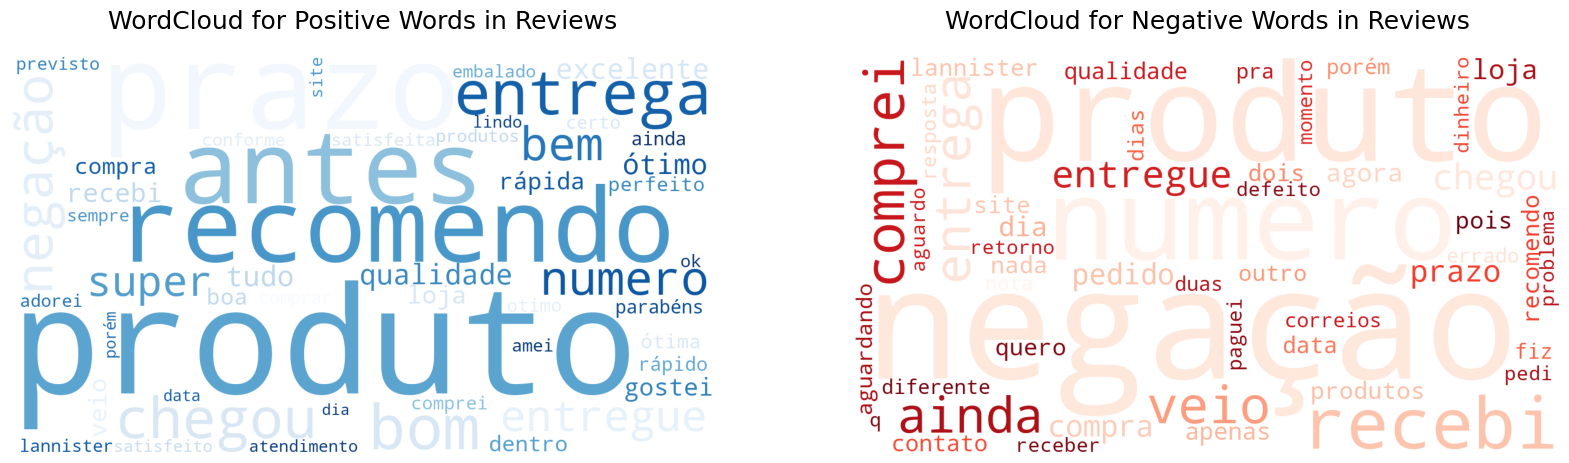

In [969]:
# Generating words
pos_comments = list(df_sentiment_analysis.query('sentiment_label == "positive"')['processed_review_comment_message'].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(df_sentiment_analysis.query('sentiment_label == "negative"')['processed_review_comment_message'].values)
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42,
                      colormap='Blues', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews',size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews',size=18, pad=20)

plt.show()

### Part V: Full Analysis and Vizualization in English

We now look to analyse the reviews in English, using the finalized English reviews. Our goal for analysing the reviews is to better understand customer sentiments as well as the biggest issues faced by them. We look to identify problems which might attribute to low ratings and negative sentiments, proposing stopgap or permanent solutions to the issues.

To do this, we have decided to understand both the micro (i.e. across products and categories) and the macro (i.e. across all products) aspects of customer reviews, analyzing both the positives and shortcomings for furture improvements, and our analysis will be as follows:

**1. Review and Sentiment Analysis by Category**

    a. Average Review Scores 

    b. Sentiment Distribution 

**2. Review and Sentiment Analysis across All Products**

    a. N-grams of Postive and Negative Review Labels (English)

    b. WordCloud for Positive and Negative Reviews (English)

**3. Review Response Time Analysis**

    a. Average Response Time vs. Sentiment by Review Score

    b. Average Response Time by Product Category
    
**4. Time Series of Product Sentiment Over Time**

#### 1. Review and Sentiment Analysis by Category

##### a. Average Review Scores by Category

Here, we plot a simple table depicting the review scores by category. We then segmented the the categories based on their review score by color of the cells (i.e. `blue` for review_scores ≥ 4.00, `green` for review_scores between 3.90 and 3.80, `yellow` for review_scores between 3.80 and 3.70, `orange` for review_scores between 3.70 and 3.60 and `red` for review_scores < 3.60)

In [970]:
# Calculate the average review score for each product category
avg_scores_by_category = df_sentiment_analysis.groupby('broader_category_english')['review_score'].mean().round(2)

# Sort by average review score (optional)
avg_scores_by_category = avg_scores_by_category.sort_values(ascending=False)

# Calculate the overall average review score
overall_avg_score = avg_scores_by_category.mean().round(2)

# Prepare data for the table, including the overall average row
categories = avg_scores_by_category.index.tolist() + ["Overall Average"]
average_scores = [f"{score:.2f}" for score in avg_scores_by_category.values.tolist()] + [f"{overall_avg_score:.2f}"]

# Apply colors to each score, with a different color for the "Overall Average" row
cell_colors = [
    [
        get_color(float(score)) if category != "Overall Average" else '#f0f0f0' 
        for category, score in zip(categories, average_scores)
    ]
]

# Create the Plotly table with conditional formatting for rows
fig = go.Figure(data=[go.Table(
    columnorder=[1, 2],
    header=dict(
        values=["Product Category", "Average Review Score"],
        fill_color='lightgrey',
        align='center',
        font=dict(color='black', size=14)
    ),
    cells=dict(
        values=[categories, average_scores],
        fill_color=cell_colors, 
        align='center',
        font=dict(color='black', size=12),
        height=40
    )
)])

# Update layout
fig.update_layout(
    title="Average Review Scores by Product Category",
    height=600,  
    margin={"t": 50, "b": 100, "l": 100},  
    plot_bgcolor="white",  
    paper_bgcolor="white",  
    annotations=[
        dict(
            x=0.5,  
            y=-0.1, 
            xref="paper",
            yref="paper",
            text="Legend of Scores",
            showarrow=False,
            font=dict(size=14, color="black"),
            align="center",
            borderpad=10,
        ),
        dict(
            x=0.18,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="Score ≥ 4.00",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            bgcolor='#c6f7e2',
            borderpad=5,
            opacity=0.8
        ),
        dict(
            x=0.35,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="3.90 > Score ≥ 3.80",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            bgcolor='#d9f0c3',
            borderpad=5,
            opacity=0.8
        ),
        dict(
            x=0.5,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="3.80 > Score ≥ 3.70",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            bgcolor='#fef4c3',
            borderpad=5,
            opacity=0.8
        ),
        dict(
            x=0.65,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="3.70 > Score ≥ 3.60",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            bgcolor='#fde0c5',
            borderpad=5,
            opacity=0.8
        ),
        dict(
            x=0.82,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="Score < 3.60",
            showarrow=False,
            font=dict(size=12, color="black"),
            align="center",
            bgcolor='#f9c2c2',
            borderpad=5,
            opacity=0.8
        )
    ]
)

fig.show()

Analysis:

From the table, we can see that the Average Rating is 3.78 where "Books & Media" has the highest rating of 4.06 and "Electronics & Appliances" have the lowest rating of 3.60. 

In segmenting the categories by score, we also see that "Book & Media" is the only category colored "blue", with a review score greater than 4.00.
Meanwhile, "Fashion", "Food & Drink", "Toys & Games", and "Health & Beauty" are colored "green", with a review score between 3.90 and 3.80,
"Sports & Leisure", "Miscellaneous" and "Automotive & Industry" are colored "yellow", with a review score between 3.80 and 3.70, and finally,
"Home & Living" and "Electronics & Appliances" are colored "red", with review scores between 3.70 and 3.60.

From this we can see that none of the average ratings of the categories fall below 3.60.

#### b. Sentiment Distribution by Category (Using Bar Charts and HeatMaps)

From the previous vizualization, we now want to dive deeper into the breakdown of number of positive and negative reviews per category to understand how customers generally feel about the product. 

We first look at a `horizontal bar chart` to see the total number of positive and negative reviews, and the sentiment spread within each category.

In [971]:
# Group by product category and sentiment label, and count the occurrences of each sentiment
sentiment_counts = df_sentiment_analysis.groupby(['broader_category_english', 'sentiment_label']).size().reset_index(name='review_count')

# Calculate the total number of reviews per product category (positive + negative combined)
total_reviews = sentiment_counts.groupby('broader_category_english')['review_count'].sum().reset_index(name='total_reviews')

# Merge the total reviews into the sentiment_counts dataframe
sentiment_counts = sentiment_counts.merge(total_reviews, on='broader_category_english')

# Create a horizontal bar chart for positive and negative reviews
fig_stacked = px.bar(
    sentiment_counts,
    y='broader_category_english',  
    x='review_count',  
    color='sentiment_label',  
    title="Sentiment Distribution by Product Category",
    labels={
        "broader_category_english": "Product Category", 
        "review_count": "Number of Reviews", 
        "sentiment_label": "Sentiment"
    },
    category_orders={"sentiment_label": ["positive", "negative"]},  
    height=600,
    orientation='h', 
    hover_data={
        'review_count': True,  
        'broader_category_english': True, 
    },
    text='review_count',  
    text_auto=True,  
)

# Update hovertemplate to show total reviews 
fig_stacked.update_traces(
    hovertemplate=(
        "Product Category: %{customdata[0]}<br>"  
        "Sentiment: %{customdata[1]}<br>"  
        "Number of Reviews: %{x}<br>"  
        "<extra></extra>"  
    ),
    customdata=sentiment_counts[['broader_category_english', 'sentiment_label']].values
)

# Format the x-axis numbers to display with commas
fig_stacked.update_layout(
    xaxis_tickformat=',',
)

# Show the plot
fig_stacked.show()

From the above horizontal bar chart, we can see that "Home and Living" has the most number of reviews at 12,335 reviews, whilst "Book & Media" has the lowest number of reviews at 299 reviews. Althought "Home and Living" has the most number of positive reviews, understanding the percentage of positive to negative reviews per category would give a fairer representation of how each category faired.

Thus, our next visualisation will be a `HeatMap` of Positive and Negative Sentiments by Category, highlighting the percentage breakdown of positive to negative by category, and also comparing it across other categories.

In [972]:
#### Creating Heatmap of Product Category and Sentiment Label
# Group by product category and sentiment label, and count the occurrences of each sentiment
sentiment_counts = df_sentiment_analysis.groupby(['broader_category_english', 'sentiment_label']).size().unstack(fill_value=0)

# Calculate the percentage of each sentiment by category
sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Round the percentages to 1 decimal place
sentiment_percentage_rounded = sentiment_percentage.round(1)

# Manually transpose the dataframe to ensure that the product categories are on the vertical axis and sentiment labels on the horizontal axis
sentiment_percentage_transposed = sentiment_percentage_rounded.T

# Create the heatmap with flipped axes
fig_heatmap = px.imshow(
    sentiment_percentage_transposed, 
    labels=dict(x="Sentiment", y="Product Category", color="Percentage"),
    x=sentiment_percentage_transposed.columns,  
    y=sentiment_percentage_transposed.index,  
    color_continuous_scale='RdYlGn',  
    title="Sentiment Distribution by Product Category",
    text_auto=False  
)

# Add custom text showing the rounded percentages
fig_heatmap.update_traces(
    text=sentiment_percentage_transposed.values,  
    texttemplate="%{text:.1f}%", 
    hovertemplate='Product Category: %{y}<br>Sentiment: %{x}<br>Percentage: %{text}%', 
)

# Adjust x and y axis labels
fig_heatmap.update_layout(
    yaxis=dict(tickfont = dict(size=9)),
    xaxis=dict(tickangle=0, tickfont=dict(size=9)) 
)

fig_heatmap.show()

The HeatMap shows us that although "Home and Living" has the most number of positive reviews, its positive reviews only account for 73.1% of all its total reviews. On the other hand, although "Books & Media" might have the lowest number of positive reviews, it actually has the highest percentage of positive to negative reviews when compared to the other categories.

In fact, "Books & Media" has the highest ratio of positive to negative reviews, whereas "Home & Living" ranks second bottom of ratio of positive to negative reviews, with the lowest being "Electronics & Appliances". This also means that "Electronics & Appliances" has the lowest difference between positive and negative reviews, in other words, relative to other categories, it is the most "neutral" (or "negative") category.

To conclude, based on positive review percentages, "Books & Media" category is the most "positive" category, whilst "Electronics & Appliances" is the most "neutral" (or "negative") category

Where "Home and Living" is the most reviewed category, and "Books & Media" the least

#### 2. Review and Sentiment Analysis across All Products

To better understand the overall sentiment, themes or topics that consumers are most passionate about, we decide to do review and sentiment analysis across all products (We also do this by category, but the results are in our dashboard). By doing this, we can identify overall trends and topics across all products to determine the biggest talking points and issues. 

We choose to do this using `N-Grams of Positive and Negative Reviews` as well as `Word Clouds of Positive and Negative Reviews`, similar to what we did above with the Portuguese words.

##### a. N-grams of Postive and Negative Review Labels (English)

N-grams are sequences of n consecutive words or tokens used to analyze text patterns. In product reviews, n-grams help capture common phrases and expressions that reflect customer sentiment. In our case we choose to do N-grams (where, N = 1, 2, 3).

Unigrams (1-word sequences or 1-grams) are useful reveal individual positive or negative words like "excellent" or "disappointed."
Bigrams (2-word sequences or 2-grams) and Trigrams (3-word sequences or 3-grams) capture short phrases, such as "high quality" or "not worth," which are often more informative in sentiment analysis.

By analyzing n-grams, we can identify frequent phrases that provide insights into customer opinions about products.

In [973]:
# N-grams in English
# Separate positive and negative reviews
positive_reviews = df_sentiment_analysis[df_sentiment_analysis['sentiment_label'] == 'positive']['review_en_final'].dropna()
negative_reviews = df_sentiment_analysis[df_sentiment_analysis['sentiment_label'] == 'negative']['review_en_final'].dropna()

# Get top unigrams, bigrams, trigrams
top_unigrams_pos = get_top_ngrams(positive_reviews, ngram_range=(1, 1), n=10)
top_bigrams_pos = get_top_ngrams(positive_reviews, ngram_range=(2, 2), n=10)
top_trigrams_pos = get_top_ngrams(positive_reviews, ngram_range=(3, 3), n=10)

top_unigrams_neg = get_top_ngrams(negative_reviews, ngram_range=(1, 1), n=10)
top_bigrams_neg = get_top_ngrams(negative_reviews, ngram_range=(2, 2), n=10)
top_trigrams_neg = get_top_ngrams(negative_reviews, ngram_range=(3, 3), n=10)

# Plotting
fig = make_subplots(
    rows=3, cols=2,  
    subplot_titles=(
        "Top Unigrams on Positive Comments", "Top Unigrams on Negative Comments",
        "Top Bigrams on Positive Comments", "Top Bigrams on Negative Comments",
        "Top Trigrams on Positive Comments", "Top Trigrams on Negative Comments"
    ),
    vertical_spacing = 0.07,
    horizontal_spacing = 0.25
)

# Adding Unigram Plots 
words, counts = ngram_data(top_unigrams_pos)
colors = color_gradient(counts, (173, 216, 230), (0, 0, 255))  
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=1, col=1)

words, counts = ngram_data(top_unigrams_neg)
colors = color_gradient(counts, (255, 160, 122), (139, 0, 0))  
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=1, col=2)

# Adding Bigram Plots
words, counts = ngram_data(top_bigrams_pos)
colors = color_gradient(counts, (173, 216, 230), (0, 0, 255))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=2, col=1)

words, counts = ngram_data(top_bigrams_neg)
colors = color_gradient(counts, (255, 160, 122), (139, 0, 0))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=2, col=2)

# Adding Trigram Plots
words, counts = ngram_data(top_trigrams_pos)
colors = color_gradient(counts, (173, 216, 230), (0, 0, 255))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=3, col=1)

words, counts = ngram_data(top_trigrams_neg)
colors = color_gradient(counts, (255, 160, 122), (139, 0, 0))
fig.add_trace(go.Bar(x=counts, y=words, orientation='h', marker=dict(color=colors)), row=3, col=2)

# Update layout
fig.update_layout(
    height=1500, width=1000, title_text="Top N-grams on Positive and Negative Comments",
    showlegend=False
)

# Reverse y-axes to have top n-grams at the top for each plot
for i in range(1, 4):
    fig.update_yaxes(autorange="reversed", row=i, col=1)
    fig.update_yaxes(autorange="reversed", row=i, col=2)

fig.show()


N.B.
In deciding to use only N =3: Ultimately, we chose to do it up to trigrams because we want to balnce both efficiency but also receiving valuable insights. When we tried to do 4-grams, we realised that the insights gained were very similar to trigrams (from bigrams to trigrams we already notice that). Hence, we decided that trigrams were sufficient to receive the insights we need without expending too much resources

#### b. WordCloud of Postive and Negative Review (English)

Word Clouds are visual representations of text data where the size of each word reflects its frequency or importance in the dataset. In product reviews, word clouds highlight commonly mentioned words, making it easy to spot key themes or frequent terms in customer feedback.

In our Word Clouds, Positive reviews may show words like "amazing" or "recommend," while negative reviews might highlight "poor" or "refund." Word clouds provide an intuitive, quick overview of dominant sentiments and topics in reviews, supporting deeper text analysis and insights into customer perceptions.

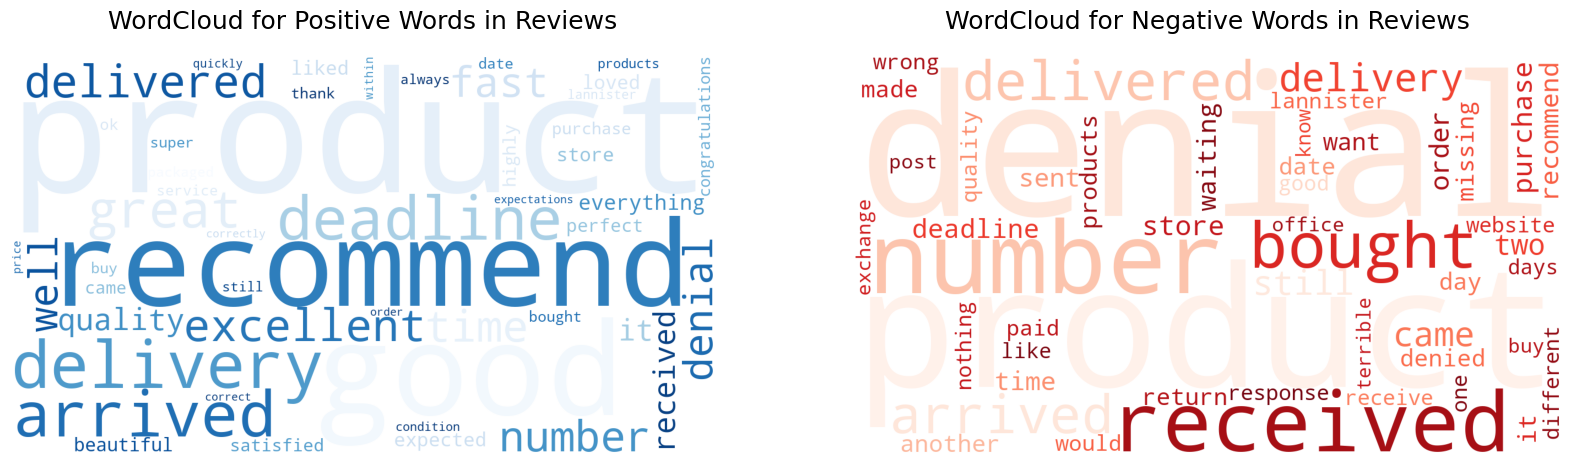

In [974]:
#WordCloud in English
# Generating words
pos_comments = list(df_sentiment_analysis.query('sentiment_label == "positive"')['review_en_final'])
pos_comments = [str(comment) for comment in pos_comments]
positive_words = ' '.join(pos_comments).split(' ')

neg_comments = list(df_sentiment_analysis.query('sentiment_label == "negative"')['review_en_final'])
neg_comments = [str(comment) for comment in neg_comments] 
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42,
                      colormap='Blues', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each Cloud
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews',size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews',size=18, pad=20)

plt.show()

In our Word Cloud of Positive and Negative words,
'product', 'recommend', 'delivery' and 'arrived' appear a lot in positive reviews, whilst 'denial (or no equivalents)', 'product', 'nothing', 'wrong' appear a lot in negative reviews, coinciding with our top unigram words we had derived from our N-gram analysis.

These common words such as 'beautiful' and 'excellent or 'wrong' and 'missing' are often associated with positive and negative feelings, which ultimately make sense in positive and negative reviews

From our two figure aboves, we can see that it is relatively identical (with a few translation differences) to the Portuguese one, thus we know the translation process did not lose significant indformation of the reviews.

Or top insights from the N-grams and Word Clouds are:
1. **Customers Value their Order Delivery Times** - where a large portion of the positive and negative reviews have phrases alluding to being satisfied with "fast" or "receiving before or at deadline" and dissatisfied with "still undelivered" and "no product received"
2. **Customers are more likely to Recommend and Rate a Product Highly if the Quality of the Product is Good** - where we see that a lot of the reviews have "highly recommend" with "good quality" in the same comments, appearing in the positive n-grams portion

#### 3. Review Response Time Analysis

Review response time analysis measures how quickly companies respond to customer reviews. This metric helps identify how responsive a business is, which can influence customer satisfaction and trust. Fast response times often signal strong customer service and can improve customer perception, while slow responses might indicate issues in customer care.

Analyzing response times can reveal trends and areas needing improvement, such as whether negative reviews take longer to address than positive ones. Ultimately, understanding response times helps businesses improve service efficiency and align response practices with customer expectations, potentially boosting loyalty and satisfaction.

We thus analyse Review Respone Times in two ways:

a. Average Response Time vs. Sentiment by Review Score

b. Average Response Time by Category

##### a. Average Response Time vs. Sentiment by Review Score

Analyzing average response time versus sentiment by review score reveals how quickly businesses respond to reviews of varying sentiment and rating levels. This approach provides insight into whether reviews with lower scores or negative sentiment receive faster attention, potentially as part of a company's effort to resolve issues and improve customer experience.

Conversely, if high-scoring reviews are answered more promptly, it may highlight a focus on nurturing positive relationships. By examining this relationship, companies can evaluate the consistency and effectiveness of their customer service approach, identifying areas where response strategies could better align with customer needs and sentiment.

We do this by using a bar chart and trend line to explore the relationship

In [975]:
# Filter out rows where review_score is 0
df_filtered = df_sentiment_analysis[df_sentiment_analysis['review_score'] != 0]

# Calculate the average response time for positive and negative sentiment labels, grouped by review_score
avg_response_time = df_filtered.groupby(['sentiment_label', 'review_score'])['response_time_hours'].mean().reset_index()

# Calculate the overall average response time across all sentiment labels
overall_avg_response_time = df_sentiment_analysis['response_time_hours'].mean()

# Create the bar chart comparing average response time for positive vs. negative sentiment, by review score
fig = px.bar(
    avg_response_time,
    x='review_score',  
    y='response_time_hours',  
    color='sentiment_label',  
    title="Average Response Time vs. Sentiment by Review Score",
    labels={"sentiment_label": "Sentiment", "response_time_hours": "Average Response Time (Hours)", "review_score": "Review Score"},
    color_discrete_map={'positive': '#8DBBCC', 'negative': 'salmon'}, 
    text='response_time_hours', 
)

# Add custom data (sentiment_label) for hovertext
fig.update_traces(customdata=avg_response_time[['sentiment_label']].values)

#Changing Hover Text
fig.update_traces(
    hovertemplate=
    'Review Score: %{x}<br>' +            
    'Average Response Time: %{y:.2f} Hours'  
)

# Use texttemplate to round the numbers to one decimal place
fig.update_traces(texttemplate='%{text:.2f} Hours', textposition='inside')

# Add a reference line for the overall average response time
fig.add_shape(
    type='line',
    x0=-0.5, x1=6,  
    y0=overall_avg_response_time, y1=overall_avg_response_time,  
    line=dict(color='blue', width=2, dash='dash') 
)

# Add annotation for the overall average line
fig.add_annotation(
    x=2,  
    y=overall_avg_response_time + 1,
    text=f"Overall Average: {overall_avg_response_time:.2f} Hours",
    showarrow=False,
    font=dict(size=12, color='blue'),
    align='center'
)

# Create a line graph to show the trend of average response time by review score
# Here we calculate the average response time across all sentiments for each review score
avg_response_by_score = df_filtered.groupby('review_score')['response_time_hours'].mean().reset_index()

# Add the line graph over the bar chart
fig.add_trace(
    go.Scatter(
        x=avg_response_by_score['review_score'],
        y=avg_response_by_score['response_time_hours'],
        mode='lines+markers',  
        name='Average Response Time',  
        line=dict(color='grey', width=3), 
        marker=dict(size=6, color='grey') 
    )
)

# Update the layout to set the y-axis range from 70 to 80
fig.update_layout(
    yaxis=dict(
        range=[70, 80]
    ),
    bargap=0.2, 
    bargroupgap=0,  
    xaxis=dict(
        range=[0.2, 5.8], 
    )
)

fig.show()

From the above visaulisation, we can see that the overall average response time for all reviews is 76.15 hours, where review score of 2 has the fastest response time of 72.77 hours and review score of 5 has the longest response time. The trend line roughly shows a positive relationship between review score and average response time, with exception of review score of 1. As a whole, negative reviews are responded at a much faster time as compared to negative reviews.

**Possible Reason for Trend**:
Negative reviews tend to receive faster responses because they highlight customer dissatisfaction, which businesses are often motivated to address quickly. Quick responses to negative reviews help mitigate potential damage to a company's reputation by showing customers that their feedback is taken seriously and that the company is committed to resolving issues. This can turn a negative experience into a positive one, improve customer loyalty, and demonstrate proactive customer service to other potential customers. Addressing negative feedback promptly can also reduce the likelihood of further complaints or negative word-of-mouth, making it a valuable strategy in reputation management. Furthermore, positive reviews are less likely to be questions that need to be answered, but rather compliments or statements.

##### b. Average Response Time by Product Category

Next we analyze Average Response Time by Product Category. Analyzing Average Response Time by Product Category helps identify which types of products generate the most or least timely responses, highlighting possible trends in customer service prioritization. If certain categories consistently receive slower responses, it may signal operational inefficiencies or insufficient support resources for those products. This analysis can reveal customer service patterns and areas needing improvement, enabling businesses to allocate resources more effectively. Additionally, comparing response times by category may help identify if specific products trigger more complex customer issues, requiring more time and specialized support to address.

In [976]:
# Group by product category and calculate the average response time for each category
avg_response_time_by_category = df_sentiment_analysis.groupby('broader_category_english')['response_time_hours'].mean().reset_index()

# Sort the dataframe in ascending order based on the average response time
avg_response_time_by_category = avg_response_time_by_category.sort_values('response_time_hours', ascending=True)

# Create a bar chart to visualize average response time by product category
fig = px.bar(
    avg_response_time_by_category,
    x='broader_category_english',  
    y='response_time_hours',  
    title="Average Response Time by Product Category",
    labels={"broader_category_english": "Product Category", "response_time_hours": "Average Response Time (Hours)"},
    color='response_time_hours',  
    color_continuous_scale='Viridis',
)

# Use texttemplate to show the average response time on the bars, rounded to one decimal place
fig.update_traces(texttemplate='%{y:.2f}<br>'+ 'Hours',
                    textposition='inside', 
                    textfont=dict(size=10),
                    textangle=0,
                    hovertemplate= 'Product Category: %{x}<br>' + 'Average Response Time: %{y:.2f} hours')
                
# Update layout for better display
fig.update_layout(
    yaxis=dict(range=[60, 85]),
    xaxis=dict(tickangle=20, tickfont=dict(size=10)),
    bargap=0.2, 
)

# Show the plot
fig.show()


The above analysis shows that "Food & Drink" category has the fastest response time of 65.02 hours and the "Health & Beauty" category has the longest response time of 81.64 hours.

In comparison to their categories' average rating, "Books & Media", "Fashion", "Food and Drink" have the three top ratings, and also has the three fastest response time. However, the three lowest rated categories, "Automotive & Industry", "Home and Living" and "Electronics & Appliances" have the median response times. 

This shows that there **may be a correlation between fast response times and ratings**, and it could definitely be useful to allocate resources to improve review response times to improve product ratings and sentiments, and more could be done to explore this conclusion.

#### 4. Time Series of Product Sentiments Over Time

Finally, we choose to analyse a Time Series of Product Sentiments Over Time. A Time Series of Product Sentiments Over Time provides insights into trends in customer satisfaction and sentiment shifts for individual products. By visualizing sentiment changes, businesses can identify patterns, such as seasonal fluctuations or impacts from product updates, launches, or events. Sudden shifts toward negative sentiment, for example, might signal emerging issues requiring immediate action. Analyzing sentiment trends over time also allows companies to measure the long-term effectiveness of product improvements, customer service interventions, and marketing efforts. This helps businesses adapt strategies proactively and focus on maintaining or improving customer satisfaction.

In our visualisation, we choose to analyse the sentiment trends of the **top 3 most reviewed products** over time. We look to illustrate this with a scatter line of average ratings over time, with an overall trend line to illustrate the changes.

In [977]:
# Ensure the review_creation_date column is in datetime format
df_sentiment_analysis['review_creation_date'] = pd.to_datetime(df_sentiment_analysis['review_creation_date'])

# Identify the top 3 most reviewed products
top_products = (
    df_sentiment_analysis['product_id']
    .value_counts()
    .nlargest(3) 
    .index.tolist()
)

# Create a subplot figure with 3 rows and 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.04)

# Plot average ratings over time for each of the top products by month
for i, product_id in enumerate(top_products, start=1):
    product_data = df_sentiment_analysis[df_sentiment_analysis['product_id'] == product_id]
    product_data['month'] = product_data['review_creation_date'].dt.to_period("M")
    avg_rating_by_month = product_data.groupby('month')['review_score'].mean().reset_index()
    
    # Convert the 'month' period back to a timestamp for Plotly compatibility
    avg_rating_by_month['month'] = avg_rating_by_month['month'].dt.to_timestamp()
    
    # Scatter plot for the product's average rating
    fig.add_trace(
        go.Scatter(
            x=avg_rating_by_month['month'],
            y=avg_rating_by_month['review_score'],
            mode='lines',
            name=f'{product_id}'
        ),
        row=i, col=1
    )

    # Trendline using linear regression
    # Perform linear regression
    x_values = np.arange(len(avg_rating_by_month))  
    y_values = avg_rating_by_month['review_score'].values 

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)

    # Calculate trendline values (fitted line)
    trendline_y = slope * x_values + intercept
    
    # Scatter plot for the trendline
    fig.add_trace(
        go.Scatter(
            x=avg_rating_by_month['month'],
            y=trendline_y,
            mode='lines',
            name=f'{product_id} Trendline',
            line=dict(dash='dash', color='grey'),
            showlegend=False 
        ),
        row=i, col=1
    )

# Update layout for clarity
fig.update_layout(
    height=900,  
    title_text="Average Ratings Over Time by Month for Top 3 Most Reviewed Products with Trendlines",
    showlegend=True,
    legend_title_text="Product ID:",
    hovermode="x unified"
)

# Set the y-axis range for each subplot to be from 1 to 5
for i in range(1, 4):  
    fig.update_yaxes(range=[1, 5.5], row=i, col=1)

fig.update_xaxes(title_text="Month", row=3, col=1)

# Show the plot
fig.show()

From our visualisation, we can see that the top 3 most reviewed products are:
1. Product ID: 99a4788cb24856965c36a24e339b6058
2. Product ID: 422879e10f46682990de24d770e7f83d
3. Product ID: aca2eb7d00ea1a7b8ebd4e68314663af

For Product ID: 99a4788cb24856965c36a24e339b6058, intial average rating is 3.37 and the final average rating is 3.75 (**Roughly Stagnant**)

For Product ID: 422879e10f46682990de24d770e7f83d, intial average rating is 4.41 and the final average rating is 3.85 (**Decline**)

For Product ID: aca2eb7d00ea1a7b8ebd4e68314663af, intial average rating is 3.08 and the final average rating is 4.32 (**Improvement**)



**Possible Reasons for the Trend**:

For Product ID: 99a4788cb24856965c36a24e339b6058, the ratings has remained roughly stagnant, and this could possible be due to no significant changes in product quality, customer experience, or user base. If a product consistently meets customer expectations but does not evolve, it may receive steady ratings as loyal users continue to rate it similarly over time.

For Product ID: 422879e10f46682990de24d770e7f83d, ratings may deteriorate if the product’s quality declines, such as through manufacturing issues or poor customer service. Also, as competitors introduce superior offerings, customer expectations may shift, leading to a more critical view of the product. Additionally, a larger user base or changing customer demographics might bring in more varied perspectives, including negative experiences that lower average ratings.

For Product ID: aca2eb7d00ea1a7b8ebd4e68314663af, ratings may often improve due to product updates, feature enhancements, or customer service improvements. A company that actively addresses negative feedback or continuously innovates can see a rise in ratings as more customers are satisfied. Positive word-of-mouth and marketing efforts also contribute to this trend.


#### Conclusion

Overall, these analyses highlight the trends and relationships between different variables. Looking at the reviews, ratings and sentiment labels ultimately help to give insights into how products, categories and the overall business can improve, or account for certain trends and phenomena.

## Chapter 2. Machine Learning for Sentiment Analysis - Predicting Customer Sentiment

After performing EDA on the reviews, we next decided to build a machine learning model to predict the sentiment of customer reviews without the need of a review score by leveraging the cleaning and analysis done we had previously. By utilizing the labeled reviews data, our goal is to create a model that is trained to classify reviews as either positive or negative, based on their content. This model will employ feature extraction techniques such as the use of CountVectorizer and sentiment-specific patterns to enhance accuracy. Our goal is to simulate a real-time sentiment analysis system that can predict review sentiment instantly as new data arrives. This will allow for continuous, automated feedback monitoring and provide businesses with up-to-date insights into customer sentiment on an ongoing basis.

### Part I. Feature Extraction (for Traning of Machine Learning Model)

Firstly, to train our Machine Learning Model, we have to perform Feature Extraction. Feature extraction is crucial for machine learning because it transforms raw data into numerical representations that models can process. By extracting relevant features, we enable algorithms to detect patterns and make accurate predictions. It helps improve model efficiency, reduces dimensionality, and ensures meaningful input for learning algorithms.

#### a. Feature Extraction

In our case, Feature extraction with CountVectorizer converts the text corpus into a numerical matrix, where each feature corresponds to the frequency of a word or token. The code extracts the most relevant words based on specific criteria, like frequency thresholds, and transforms the features into a DataFrame for easier interpretation and analysis.

In [978]:
#### Using CountVectorizer
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (39666, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,algum,além,amass,ame,ant,anunci,anúnci,aparelh,apen,apes,após,assim,ate,atend,atras,avali,baix,baratheon,bast,bem,boa,bols,bom,bonit,busc,cab,cad,cade,caix,cancel,cap,car,cart,cartuch,cas,celul,cert,cheg,client,cobr,...,sab,satisf,satisfeit,segund,sei,seman,sempr,send,serviç,sim,sit,so,sobr,solicit,solt,soment,stark,sup,super,tamanh,tapet,targaryen,tec,temp,tent,ter,test,tod,top,total,trabalh,transport,troc,tud,unidad,us,uso,vai,val,vc,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


#### b. TF-IDF Approach

Here we are using the Term Frequency - Inverse Document Frequency (TF-IDF) approach to factor in weights for the frequency of the words. The TF-IDF approach assigns weights to words based on their importance in a document relative to the entire corpus. Words that appear frequently in a document but infrequently across all documents are considered more significant. In our case, we choose to apply TF-IDF to extract weighted features from the corpus.

In our case, we decided to choose the features, `max_features=300, min_df=7, max_df=0.8` because we wanted to balance between efficiency but also accuracy. As lower values would result in less acurate results, but higher values might be more computationally expensive or the model might be trained on irrelevant words and data.

In [979]:
#### Using the TF-IDF approach to factor in weights for the frequency of each word

# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
df_tfidf_features.head()

Shape of tfidf_features matrix: (39666, 300)



,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,algum,além,amass,ame,ant,anunci,anúnci,aparelh,apen,apes,após,assim,ate,atend,atras,avali,baix,baratheon,bast,bem,boa,bols,bom,bonit,busc,cab,cad,cade,caix,cancel,cap,car,cart,cartuch,cas,celul,cert,cheg,client,cobr,...,sab,satisf,satisfeit,segund,sei,seman,sempr,send,serviç,sim,sit,so,sobr,solicit,solt,soment,stark,sup,super,tamanh,tapet,targaryen,tec,temp,tent,ter,test,tod,top,total,trabalh,transport,troc,tud,unidad,us,uso,vai,val,vc,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350265,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426854,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.318293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.753284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108732,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172383,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.196369,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.598362,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258530,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.335591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.423939,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Part II: Building the Pipeline for Model Training

After creating functions in the step of 'Cleaning and Pre-Processing', we decide that it would be easier to create a Text Pipeline that enables us to apply all the functions to any text (in Portugese), so that we are able to streamline the process of cleaning any new text we intend to pass through the model. This increases efficiency of the process, preventing any processes from being left out.

In the pipeline we chose the TF-IDF approach to extract features from text using the parameters: `max_features=300`, `min_df=7`, `max_df=0.8` (i.e. every text string in the corpus will be 300 "text features" that meet the criteria defined by the min_df and max_df parameters)

In [980]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hyperlinks': re_hyperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

We then decide to split the data into train sets and test sets, which would be used for training and testing the model. We first define our df contents and then split them before processing the reviews in the pipleine. After which we verify the length of each split.


We decided to perform the analysis on the Portugese words because we fear that if we perform it on the translated reviews, there might be a significant loss of information which could affect the quality and results of the machine learning model. Additionally, we also want to preserve the original reviews as much as possible, so we chose to apply already defined functions to our pipeline, improving efficiency.

In [981]:
# Defining X and y 
idx_reviews = df['review_comment_message'].dropna().index
score = df['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(df['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


### Part III: Sentiment Classification and Model Evaluation

#### Setting Up the Models Using - _Logistic Regression_ and _Naive Bayes_

We decide to use Logistic Regression and Naive Bayes for our analysis of Positive and Negative Reviews because both are simple, efficient, and well-suited for text classification tasks like sentiment analysis. Logistic Regression works well for binary outcomes and can model relationships between features and sentiment. Naive Bayes, based on conditional probability, is effective with large datasets and handles text data well. Both algorithms are fast, interpretable, and perform well with relatively smaller datasets, making them ideal for sentiment classification in reviews. When compared to other models, they might be more computationally expensive or time-consuming, hence we chose to apply sentiment analysis using these two models and compare their results

#### Defining Model Parameters

We first define the hyperparameters of the model in order to set it up for machine learning.

In [982]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

#### Training the Models

We start by initializing the custom classifier class, `ClassifierAnalysis` on our train sets, within the class I have defined it such that the accuracy score and time are printed as outputs.

In [983]:
# Step 1: Initialize classifiers and define pipeline
clf_tool = ClassifierAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')

Training LogisticRegression...
LogisticRegression completed in 3.68s with mean CV accuracy: 0.8866
Training Naive Bayes...
Naive Bayes completed in 0.12s with mean CV accuracy: 0.8357


From the results, we see that Logistic Regression is completed much slower compared to Naive Bayes, but the Logistic Regression yields a cross-validation (CV) accuracy much higher than the Naive Bayes. To explore further which model is preferred, we can consider other evaluation metrics

#### Evaluating Models

To evaluate our models, we now decide to look at some significant metrics which play a part in evaluating the effectivenss of a model. These metrics include:
- **Accuracy**: The proportion of correct predictions (both true positives and true negatives) out of the total predictions. 
- **Precision**: The proportion of true positive predictions out of all positive predictions made by the model.
- **Recall**: Also known as sensitivity, it is the proportion of actual positives correctly identified by the model
- **F1 Score**: The harmonic mean of precision and recall. It provides a balance between the two, particularly useful when the dataset is imbalanced
- **ROC AUC Score**: The area under the Receiver Operating Characteristic curve. It measures the model's ability to distinguish between classes, with higher values indicating better performance. It ranges from 0 to 1, where 1 is perfect classification and 0.5 is no better than random guessing

In [984]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
test_metrics = {}
for name, result in clf_tool.results.items():
    model = result['model']
    y_pred = model.predict(X_test)  

    test_metrics[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) 
    }

table_data = []
for name, result in clf_tool.results.items():
    metrics_row = [
        name,
        round(test_metrics[name]['accuracy'],4),
        round(test_metrics[name]['precision'],4),
        round(test_metrics[name]['recall'],4),
        round(test_metrics[name]['f1'], 4),
        round(test_metrics[name]['roc_auc'],4)
    ]
    table_data.append(metrics_row)

columns = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

fill_colors = []
font_colors = []
for i in range(0, len(columns)): 
    column = [row[i] for row in table_data]
    fill_colors_for_column = [get_fill_color(value, column) for value in column]
    font_colors_for_column = [get_font_color(color) for color in fill_colors_for_column]

    fill_colors.append(fill_colors_for_column)
    font_colors.append(font_colors_for_column)

# Create a Plotly table
fig_table = go.Figure(go.Table(
    header=dict(
        values=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
        fill_color='#0E4D92',  
        font=dict(color='white', size=14),  
        align='center'  
    ),
    cells=dict(
        values=list(zip(*table_data)), 
        align='center',  
        font=dict(size=12, color=font_colors), 
        height=50,
        fill_color = fill_colors
    )
))

# Update layout for better appearance
fig_table.update_layout(
    title="Model Evaluation Metrics",
    height=400
)

# Show the table
fig_table.show()

#### Confusion Matrix

Similarly, we can present our findings using a confusion matrix

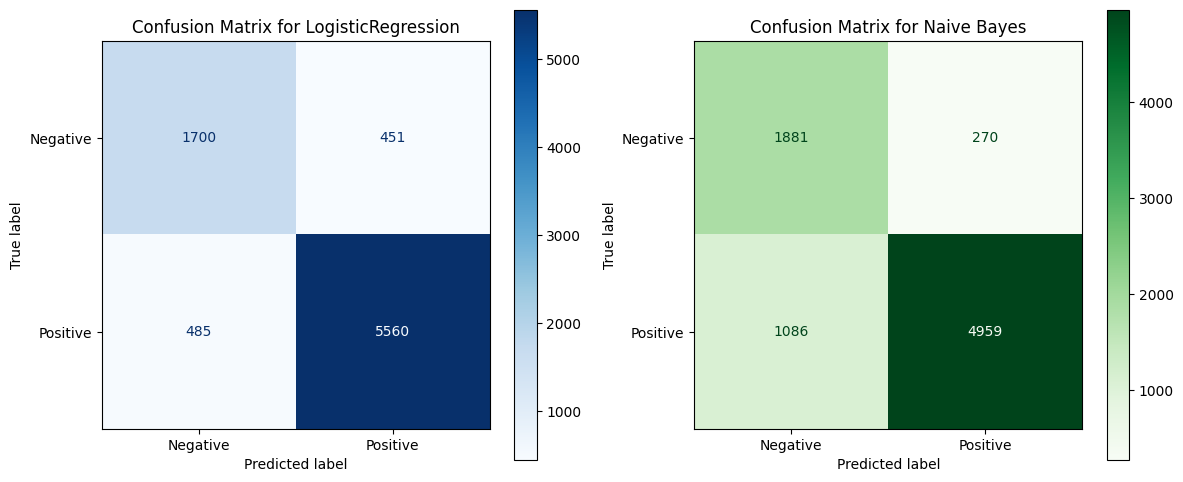

In [985]:
# Step 3: Plot Confusion Matrix
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
test_metrics = {}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
colormaps = ['Blues', 'Greens'] 

for i, (name, result) in enumerate(clf_tool.results.items()):
    model = result['model']
    y_pred = model.predict(X_test)

    test_metrics[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  
    }

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=colormaps[i], ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()

#### Conclusion
Across the board, Logistic Regression has performed better than Naive Bayes. Logistic Regression had a higher Accuracy, Recall, F1 Score and AUC, where Naive Bayes performed better at Precision. Additionally, Naive Bayes performs at a much shorter time, thus for larger datasets that could be a key factor given that the Logistic Regression was only better than Naive Bayes by a small difference in each metric.

In our case, we decided to use `Logistic Regression` for our final sentiment analsis predictor function.

### Part IV: Sentiment Analysis Prediction Functions 

We have thus defined our function for predicting sentiment analysis, by creating two separate models, `sentiment_analysis_predictor_portuguese` and `sentiment_analysis_predictor_english` which allows users to decide which function they would like to use to determine sentiment, depending on whether the text is in english or portuguese

Here, we define our inputs for the functions, using Logistic Regression as mentioned before

In [986]:
# Defining transformers for preparing the text input
logistic_model = clf_tool.results['LogisticRegression']['model']
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer


#### Examples of Function Use on Certain Texts

In these two examples, we use the `sentiment_analysis_predictor_portuguese` which predicts Portuguese text reviews.

In the output, an image of the `review sentiment` (i.e. whether it is 'Positive' or 'Negative') is displayed, along with a `percent value` at the bottom of the sentiment label, indicating the confidence level of its prediction. 

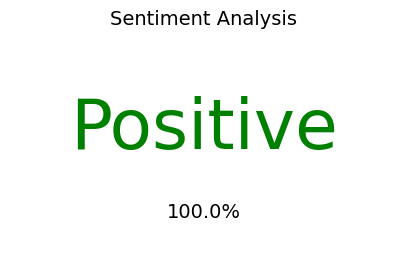

In [987]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'
sentiment_analysis_predictor_portuguese(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

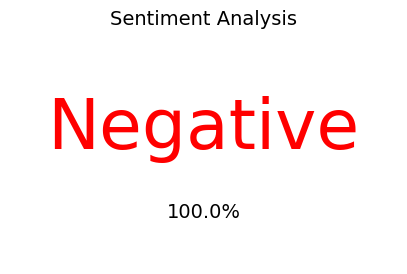

In [988]:
comment = 'Very bad product! i dont buy on this store anymore, the delivery was late and cost me so much money!'
sentiment_analysis_predictor_english(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

In this example, we use the `sentiment_analysis_predictor_english` which predicts English text reviews.

This text is the direct translation of the portugese text above, and thus shows that the English predictor is accurate in comparison to its Portuguese counterpart

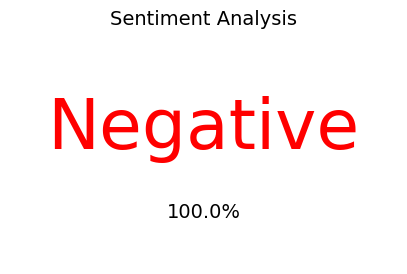

In [989]:
comment = 'Produto muito ruim! não compro mais nesta loja, a entrega atrasou e me custou muito dinheiro!'
sentiment_analysis_predictor_portuguese(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)